# 量化策略回测框架 (修改版)

## 修改核心:
1.  **单利计算**: 所有收益计算基于简单加和(cumsum)，而非复利(cumprod)。
2.  **独立交易逻辑**:
    - 根据T-1时刻的信号，在T时刻开仓。
    - 该仓位强制在T+10时刻平仓。
    - 每笔交易独立，互不影响。
3.  **数据源**: 直接使用带教老师提供的 `signal` 和 `close` 数据。
4.  **验证步骤**: 增加了回测结果与理论信号收益的相关性分析。

In [16]:
# --- 必要的库导入 ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import logging
from pandas.tseries.offsets import Week
from tabulate import tabulate
from colorama import Fore, Style
from sklearn.preprocessing import StandardScaler
import pickle
from pathlib import Path

---
## 1. 日志和绘图设置

In [17]:
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
plt.style.use('seaborn-v0_8-darkgrid') # 使用更美观的绘图风格

---
## 2. 核心回测与评估函数 (源于旧代码)

In [18]:
def run_vectorized_backtest_new(prices, signals, initial_capital=100000, commission_rate=0.0002, holding_period=10):
    """
    执行基于“独立交易”和“单利”的向量化回测。

    核心逻辑:
    - T-1时刻的信号，决定T时刻的开仓。
    - 在T时刻开仓的交易，固定在T+holding_period时刻平仓。
    - 每笔交易独立，资金无限分割。
    - 收益以单利模式累加。

    参数:
    - prices (pd.Series): 'close'价格序列。
    - signals (pd.Series): 交易信号序列 (1 for long, -1 for short, 0 for neutral)。
    - initial_capital (float): 初始资金 (主要用于最终PnL计算)。
    - commission_rate (float): 单边交易手续费率。
    - holding_period (int): 每笔交易的固定持有周期。

    返回:
    - pd.DataFrame: 包含回测详细过程的DataFrame。
    - pd.Series: 用于相关性比较的理论收益序列。
    """
    logging.info(f"🤔 开始执行新版向量化回测 (单利, {holding_period}-period持有期)...")

    # --- 1. 准备数据 ---
    # 交易决策基于上一期信号，在当期开盘时执行。shift(1)避免未来函数。
    positions = signals.shift(1).fillna(0)

    # --- 2. 计算固定持有期收益 (核心逻辑) ---
    # 计算从 t 到 t+holding_period 的未来收益率
    # 这是此策略能够捕获的理论最大收益
    forward_returns = (prices.shift(-holding_period) / prices) - 1

    # --- 3. 计算策略毛收益 ---
    # 策略在 t 时刻的收益 = t 时刻的仓位 * 从 t 到 t+10 的收益
    strategy_gross_returns = positions * forward_returns

    # --- 4. 计算交易成本 ---
    # 对于每个非零信号，都代表一次独立的开仓和平仓，所以手续费是往返的
    # 成本 = |仓位| * (开仓手续费 + 平仓手续费)
    # 注意: 这里假设每次交易都用相同比例的资金，成本是相对于该比例资金的
    transaction_costs = abs(positions) * (commission_rate * 2)

    # --- 5. 计算策略净收益 ---
    # 净收益 = 毛收益 - 交易成本
    strategy_net_returns = strategy_gross_returns - transaction_costs

    # --- 6. 计算累计收益曲线 (单利) ---
    # 使用 cumsum() 实现单利收益的累加
    cumulative_returns_simple = strategy_net_returns.cumsum().fillna(0)

    # --- 7. 整合结果 ---
    backtest_results = pd.DataFrame({
        'close': prices,
        'signal': signals,
        'position': positions, # t时刻的持仓决策
        'forward_return_10p': forward_returns, # t到t+10的收益
        'strategy_gross_returns': strategy_gross_returns, # 策略毛收益
        'transaction_costs': transaction_costs, # 交易成本
        'strategy_net_returns': strategy_net_returns, # 策略净收益
        'equity_curve_simple_return': cumulative_returns_simple # 单利累计收益率
    }).dropna() # 因为forward_returns和shift的存在，末尾会有NaN

    # 用于外部比较的理论收益序列
    theoretical_returns = positions * forward_returns

    logging.info("🎉 新版向量化回测完成。")
    return backtest_results, theoretical_returns

In [19]:
def evaluate_performance(backtest_results, evaluation_criteria, initial_capital):
    """
    评估策略表现 (已适配单利模式)。
    """
    logging.info("🤔🤔🤔 开始评估策略表现 (单利模式)...")

    # --- 数据提取 ---
    net_returns = backtest_results['strategy_net_returns']
    # 注意：这里的equity_curve是累计收益率，不是资金净值
    equity_curve = backtest_results['equity_curve_simple_return']
    
    # 构建资金曲线用于绘图和某些指标计算
    equity_curve_value = initial_capital * (1 + equity_curve)
    
    # 基准是买入并持有，仍然按复利计算，因为这是市场的真实表现
    market_returns = backtest_results['close'].pct_change().fillna(0)
    benchmark_equity = initial_capital * (1 + market_returns).cumprod()

    # --- 交易统计 ---
    # 在新模型下，每笔非零的net_returns就是一笔独立交易的最终盈亏
    trades = net_returns[net_returns != 0]
    winning_trades = trades[trades > 0]
    losing_trades = trades[trades <= 0]

    total_trades = len(trades)
    num_winning_trades = len(winning_trades)
    num_losing_trades = len(losing_trades)

    # --- 核心指标计算 (适配单利) ---
    total_days = (equity_curve.index[-1] - equity_curve.index[0]).days if len(equity_curve) > 1 else 0
    duration_years = total_days / 365.25 if total_days > 0 else 1

    # 1. 累积收益率 (Total Return)
    total_return = equity_curve.iloc[-1]

    # 2. 年化收益率 (Annualized Return) - 单利模式
    annualized_return = total_return / duration_years if duration_years > 0 else 0

    # 月度收益率 (单利聚合)
    monthly_net_returns = net_returns.resample('M').sum()

    # 3. 年化波动率 (Annualized Volatility)
    annualization_factor = 12
    if not monthly_net_returns.empty and monthly_net_returns.std() != 0:
        annualized_volatility = monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        annualized_volatility = 0

    # 4. 最大回撤 (MDD) - 基于单利收益曲线
    running_max = equity_curve.cummax()
    drawdown = running_max - equity_curve  # 回撤是峰值到谷底的绝对差值
    max_drawdown_amount = drawdown.max()
    
    # 最大回撤率需要相对于峰值时的资本
    peak_at_mdd_start = equity_curve_value.loc[drawdown.idxmax()]
    # To avoid division by zero or negative peaks in returns
    corresponding_peak_value = (1 + running_max.loc[drawdown.idxmax()]) * initial_capital
    max_drawdown_pct = max_drawdown_amount / corresponding_peak_value if corresponding_peak_value > 0 else 0


    # 5. 夏普比率 (Sharpe Ratio)
    if annualized_volatility > 0:
        # 年化夏普 = 年化收益 / 年化波动率
        sharpe_ratio = monthly_net_returns.mean() / monthly_net_returns.std() * np.sqrt(annualization_factor)
    else:
        sharpe_ratio = 0
        
    # 6. 卡玛比率 (Calmar Ratio)
    calmar_ratio = annualized_return / max_drawdown_pct if max_drawdown_pct != 0 else 0

    # 7. 胜率 & 盈亏比
    win_rate = num_winning_trades / total_trades if total_trades > 0 else 0
    total_profit = winning_trades.sum()
    total_loss = abs(losing_trades.sum())
    profit_loss_ratio = total_profit / total_loss if total_loss > 0 else np.inf

    # 8. 期望收益 (Expectancy)
    avg_win = winning_trades.mean() if num_winning_trades > 0 else 0
    avg_loss = abs(losing_trades.mean()) if num_losing_trades > 0 else 0
    expectancy = (win_rate * profit_loss_ratio) - (1 - win_rate) if win_rate > 0 and profit_loss_ratio != np.inf else -1

    # --- 打印报告 ---
    print("\n" + "="*80)
    print(Fore.CYAN + Style.BRIGHT + " " * 25 + "策略性能评估报告 (单利版)" + " " * 25 + Style.RESET_ALL)
    print("="*80)
    
    # 详细指标表格
    detail_headers = ["指标名称", "值"]
    detail_table = [
        ["模式", "单利 (Simple Interest)"],
        ["总收益率 (Total Return)", f"{total_return:.2%}"],
        ["年化收益率 (Annualized Return)", f"{annualized_return:.2%}"],
        ["年化波动率 (Annualized Vol)", f"{annualized_volatility:.2%}"],
        ["夏普比率 (Sharpe Ratio)", f"{sharpe_ratio:.4f}"],
        ["最大回撤 (Max Drawdown)", f"{max_drawdown_pct:.2%}"],
        ["卡玛比率 (Calmar Ratio)", f"{calmar_ratio:.4f}"],
        ["总交易笔数 (Total Trades)", f"{total_trades}"],
        ["胜率 (Win Rate)", f"{win_rate:.2%}"],
        ["盈亏比 (Profit/Loss Ratio)", f"{profit_loss_ratio:.4f}"],
        ["期望收益 (Expectancy)", f"{expectancy:.6f}"],
        ["平均盈利 (Avg Win)", f"{avg_win:.6f}"],
        ["平均亏损 (Avg Loss)", f"{avg_loss:.6f}"],
        ["总盈利 (Total Profit)", f"{total_profit:.4f}"],
        ["总亏损 (Total Loss)", f"{total_loss:.4f}"],
        ["最终资金 (Final Capital)", f"${equity_curve_value.iloc[-1]:,.2f}"]
    ]
    print(tabulate(detail_table, headers=detail_headers, tablefmt="grid", stralign="center", numalign="center"))
    
    # --- 绘制权益曲线图 ---
    fig, ax1 = plt.subplots(figsize=(20, 10))
    
    equity_curve_value.plot(label='Strategy Equity (Simple Interest)', lw=2, color='royalblue', ax=ax1)
    benchmark_equity.plot(label='Buy & Hold Benchmark', lw=2, linestyle='--', color='darkorange', ax=ax1)
    
    ax1.set_title('Strategy Equity Curve vs. Benchmark', fontsize=16)
    ax1.set_ylabel('Equity Value ($)', fontsize=12)
    ax1.set_xlabel('Date', fontsize=12)
    ax1.legend(fontsize=12)
    ax1.grid(True, linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    plt.show()

    logging.info("🎊🎊🎊 策略评估完成 🎊🎊🎊")

---
## 3. 主程序执行

2025-07-23 23:44:13,631 - INFO - 正在从 /public/data/_test_backtest_intern.pkl 加载数据...
2025-07-23 23:44:13,639 - INFO - 数据加载成功。
2025-07-23 23:44:13,640 - INFO - 🤔 开始执行新版向量化回测 (单利, 10-period持有期)...
2025-07-23 23:44:13,652 - INFO - 🎉 新版向量化回测完成。
2025-07-23 23:44:13,653 - INFO - 回测结果 DataFrame (前5行):
2025-07-23 23:44:13,663 - INFO - 🤔🤔🤔 开始评估策略表现 (单利模式)...


数据预览:
                     signal     close
open_time                            
2021-09-27 00:00:00       0  43050.80
2021-09-27 00:15:00       0  43048.11
2021-09-27 00:30:00       0  43431.49
2021-09-27 00:45:00       0  43851.20
2021-09-27 01:00:00       0  43912.15

数据时间范围: 2021-09-27 00:00:00 -> 2025-06-30 23:45:00
数据形状: (131808, 2)
                        close  signal  position  forward_return_10p  \
open_time                                                             
2021-09-27 00:00:00  43050.80       0       0.0            0.024668   
2021-09-27 00:15:00  43048.11       0       0.0            0.025779   
2021-09-27 00:30:00  43431.49       0       0.0            0.015576   
2021-09-27 00:45:00  43851.20       0       0.0            0.004305   
2021-09-27 01:00:00  43912.15       0       0.0            0.001121   

                     strategy_gross_returns  transaction_costs  \
open_time                                                        
2021-09-27 00:00:00         

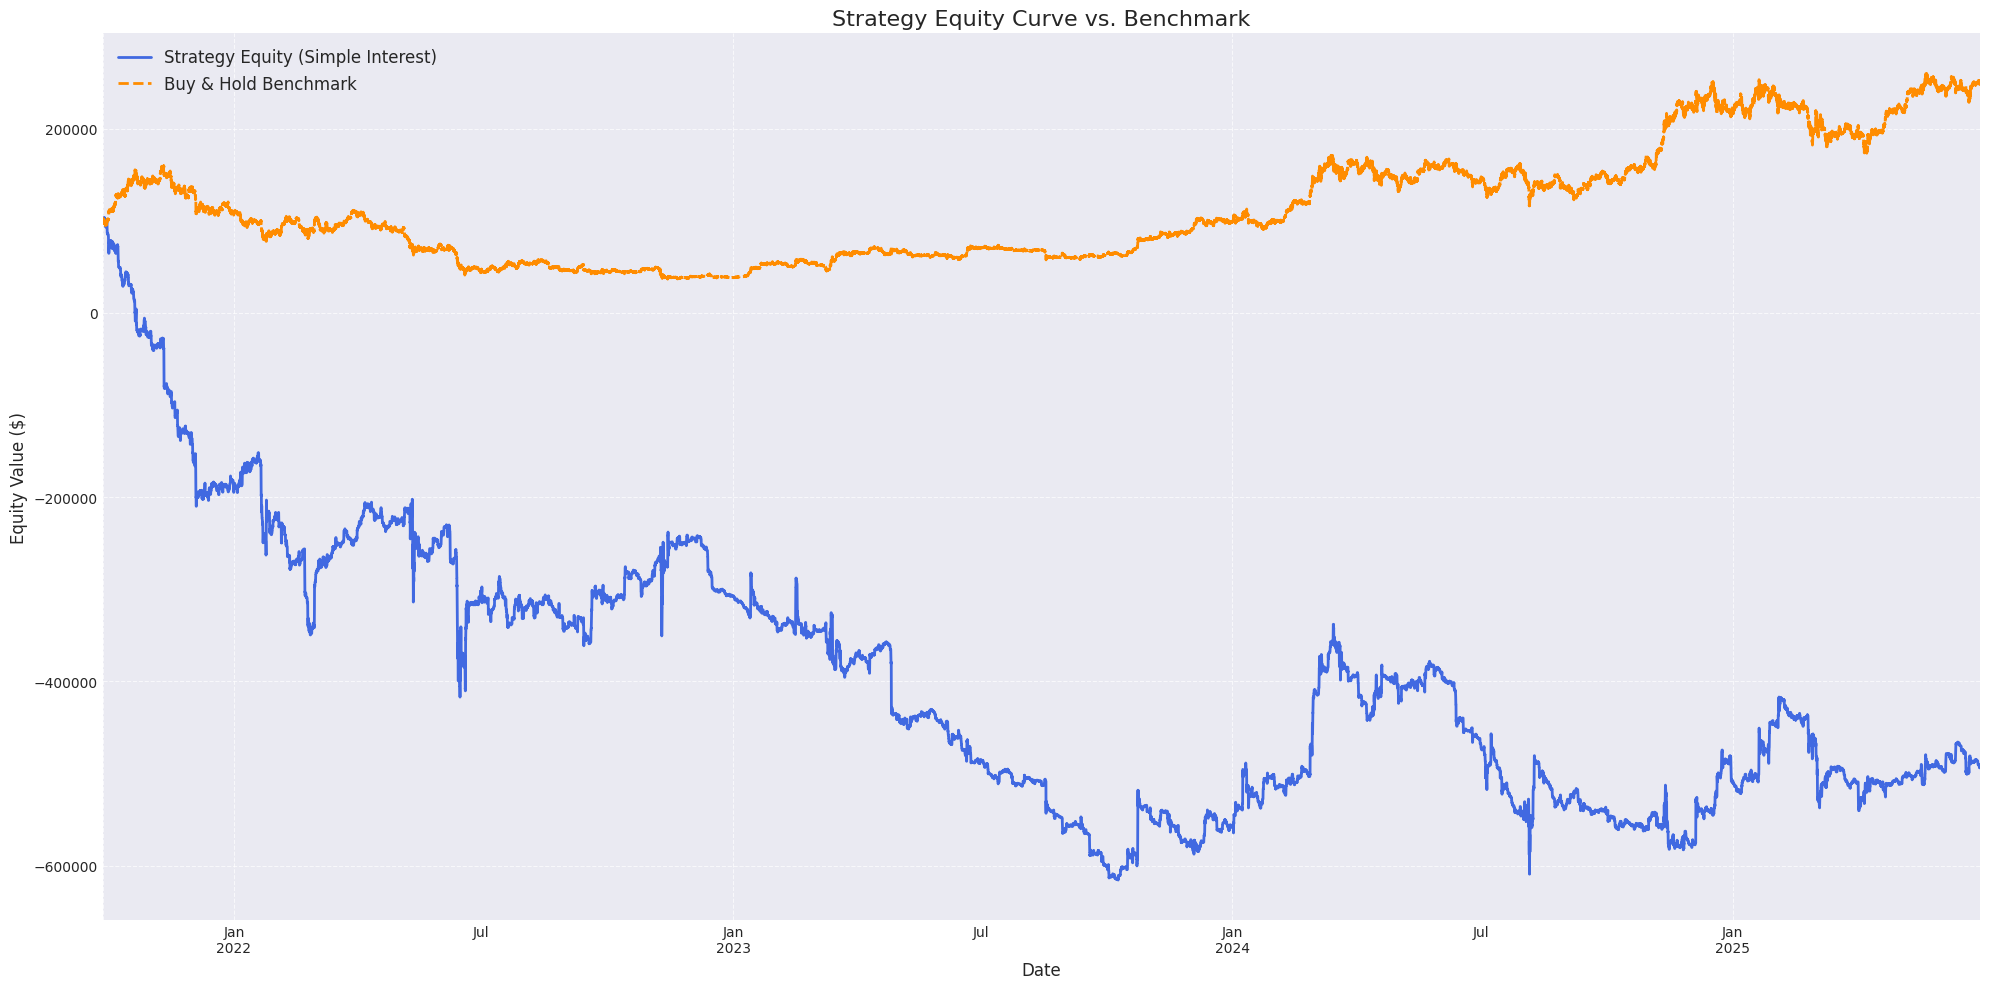

2025-07-23 23:44:16,519 - INFO - 🎊🎊🎊 策略评估完成 🎊🎊🎊


In [ ]:
if __name__ == '__main__':
    # --- 1. 参数配置 ---
    # 文件路径
    FILE_PATH = "/public/data/_test_backtest_intern.pkl"
    
    # 回测参数
    COMMISSION_RATE = 0.0002     # 单边手续费
    INITIAL_CAPITAL = 100000     # 初始资金
    HOLDING_PERIOD = 10          # 固定持有10个15分钟bar
    
    # 模型评估标准
    EVALUATION_CRITERIA = {}

    # --- 2. 数据加载 ---
    logging.info(f"正在从 {FILE_PATH} 加载数据...")
    
    file_path = Path(FILE_PATH)
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    
    # 确保索引是datetime类型
    data.index = pd.to_datetime(data.index)
    data = data.rename_axis('open_time')

    logging.info("数据加载成功。")
    print("数据预览:")
    print(data.head())
    print(f"\n数据时间范围: {data.index.min()} -> {data.index.max()}")
    print(f"数据形状: {data.shape}")

    # --- 3. 执行回测 (使用新版函数) ---
    backtest_results, theoretical_returns = run_vectorized_backtest_new(
        prices=data['close'],
        signals=data['signal'],
        initial_capital=INITIAL_CAPITAL,
        commission_rate=COMMISSION_RATE,
        holding_period=HOLDING_PERIOD
    )
    
    logging.info("回测结果 DataFrame (前5行):")
    print(backtest_results.head())

    # --- 4. 【重要】相关性检验 ---
    print("\n" + "="*80)
    print(Fore.YELLOW + Style.BRIGHT + " " * 30 + "相关性检验" + " " * 30 + Style.RESET_ALL)
    print("="*80)
    
    # 计算理论收益的累计和 (无手续费)
    theoretical_cumulative = theoretical_returns.loc[backtest_results.index].cumsum()
    
    # 获取回测的累计净收益
    backtest_cumulative_net = backtest_results['strategy_net_returns'].cumsum()
    
    # 计算两个累计收益序列的相关性
    # 这里我们比较的是“累计”收益曲线的形态相似度
    correlation = theoretical_cumulative.corr(backtest_cumulative_net)
    
    print(f"策略累计净收益 与 signal*forward_return 的累计收益 的相关系数为: {Fore.CYAN}{correlation:.8f}{Style.RESET_ALL}")
    if correlation > 0.99:
        print(Fore.GREEN + "✅ 相关性非常高，表明回测程序正确地实现了扣除手续费后的理论收益逻辑。" + Style.RESET_ALL)
    else:
        print(Fore.RED + "❌ 相关性不高，请检查手续费计算或回测逻辑中是否存在问题。" + Style.RESET_ALL)
    print("="*80 + "\n")

    # --- 5. 性能评估 (使用适配版函数) ---
    evaluate_performance(
        backtest_results, 
        EVALUATION_CRITERIA, 
        INITIAL_CAPITAL
    )